# $\textbf{Programming Assignment}$
# $\textbf{Lecture 4: K-Means Clustering}$

Instructions: Gain insights into similarity between countries and regions of hte world by experimenting with K-Means Clustering.

---

Data: [CIA Factbook](https://www.openintro.org/data/index.php?data=cia_factbook)

In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### $\textbf{1. Perform Exploratory Data Analysis}$

In [76]:
df = pd.read_csv("./datasets/cia-factbook.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  259 non-null    object 
 1   area                     257 non-null    float64
 2   birth_rate               224 non-null    float64
 3   death_rate               225 non-null    float64
 4   infant_mortality_rate    224 non-null    float64
 5   internet_users           213 non-null    float64
 6   life_exp_at_birth        224 non-null    float64
 7   maternal_mortality_rate  184 non-null    float64
 8   net_migration_rate       222 non-null    float64
 9   population               238 non-null    float64
 10  population_growth_rate   233 non-null    float64
dtypes: float64(10), object(1)
memory usage: 22.4+ KB


In [77]:
df.head()

,country,area,birth_rate,death_rate,infant_mortality_rate,internet_users,life_exp_at_birth,maternal_mortality_rate,net_migration_rate,population,population_growth_rate
0,Russia,17098242.0,11.87,13.83,7.08,40853000.0,70.16,34.0,1.69,1.424703e+08,-0.03
1,Canada,9984670.0,10.29,8.31,4.71,26960000.0,81.67,12.0,5.66,3.483484e+07,0.76
2,United States,9826675.0,13.42,8.15,6.17,245000000.0,79.56,21.0,2.45,3.188921e+08,0.77
3,China,9596960.0,12.17,7.44,14.79,389000000.0,75.15,37.0,-0.32,1.355693e+09,0.44
4,Brazil,8514877.0,14.72,6.54,19.21,75982000.0,73.28,56.0,-0.15,2.026568e+08,0.80


In [78]:
df.describe()

,area,birth_rate,death_rate,infant_mortality_rate,internet_users,life_exp_at_birth,maternal_mortality_rate,net_migration_rate,population,population_growth_rate
count,2.570000e+02,224.000000,225.000000,224.000000,2.130000e+02,224.000000,184.000000,222.000000,2.380000e+02,233.000000
mean,5.308881e+05,19.659063,7.906978,24.484420,8.311771e+06,71.826875,177.972826,-0.181577,3.229436e+07,1.100858
std,1.696869e+06,9.669575,2.979933,24.077809,3.350725e+07,8.798460,262.508297,11.142682,1.277013e+08,1.418633
min,0.000000e+00,6.720000,1.530000,1.810000,4.640000e+02,49.440000,2.000000,-113.510000,4.800000e+01,-9.730000
25%,6.160000e+02,11.840000,5.930000,6.185000,8.640000e+04,67.000000,20.000000,-2.015000,3.265865e+05,0.260000
50%,5.119700e+04,16.890000,7.630000,13.985000,7.164000e+05,74.360000,65.500000,-0.045000,5.220371e+06,1.020000
75%,3.381450e+05,24.915000,9.450000,38.655000,4.200000e+06,78.292500,240.000000,1.257500,1.826175e+07,1.920000
max,1.709824e+07,46.120000,17.490000,117.230000,3.890000e+08,89.570000,2054.000000,83.820000,1.355693e+09,9.370000


In [79]:
df.isna().sum()

country                     0
area                        2
birth_rate                 35
death_rate                 34
infant_mortality_rate      35
internet_users             46
life_exp_at_birth          35
maternal_mortality_rate    75
net_migration_rate         37
population                 21
population_growth_rate     26
dtype: int64

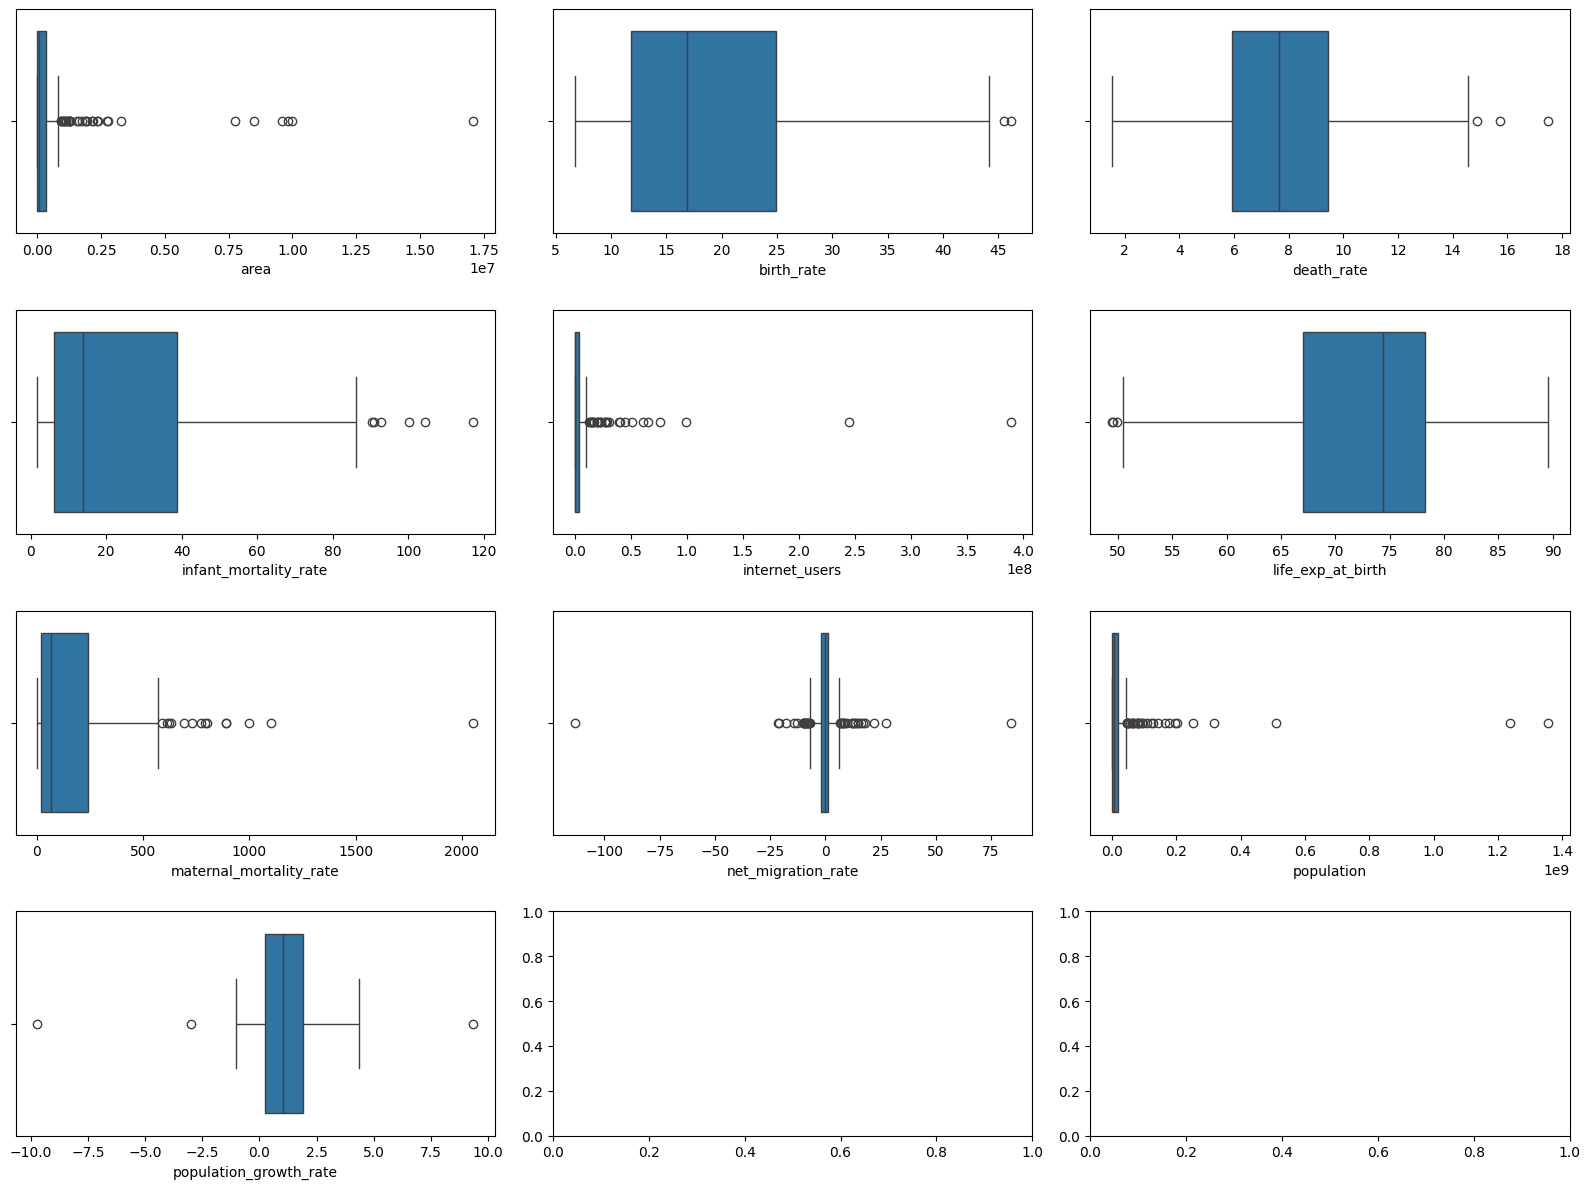

In [80]:
num_cols = 3
num_rows = len(df.columns) // num_cols + 1

_, ax = plt.subplots(num_rows, num_cols, figsize=(16, 12))
for i, col in enumerate(df.drop(columns="country").columns):
    sns.boxplot(data=df, x=col, ax=ax[i // num_cols, i % num_cols])

plt.tight_layout(h_pad=2)
plt.show()

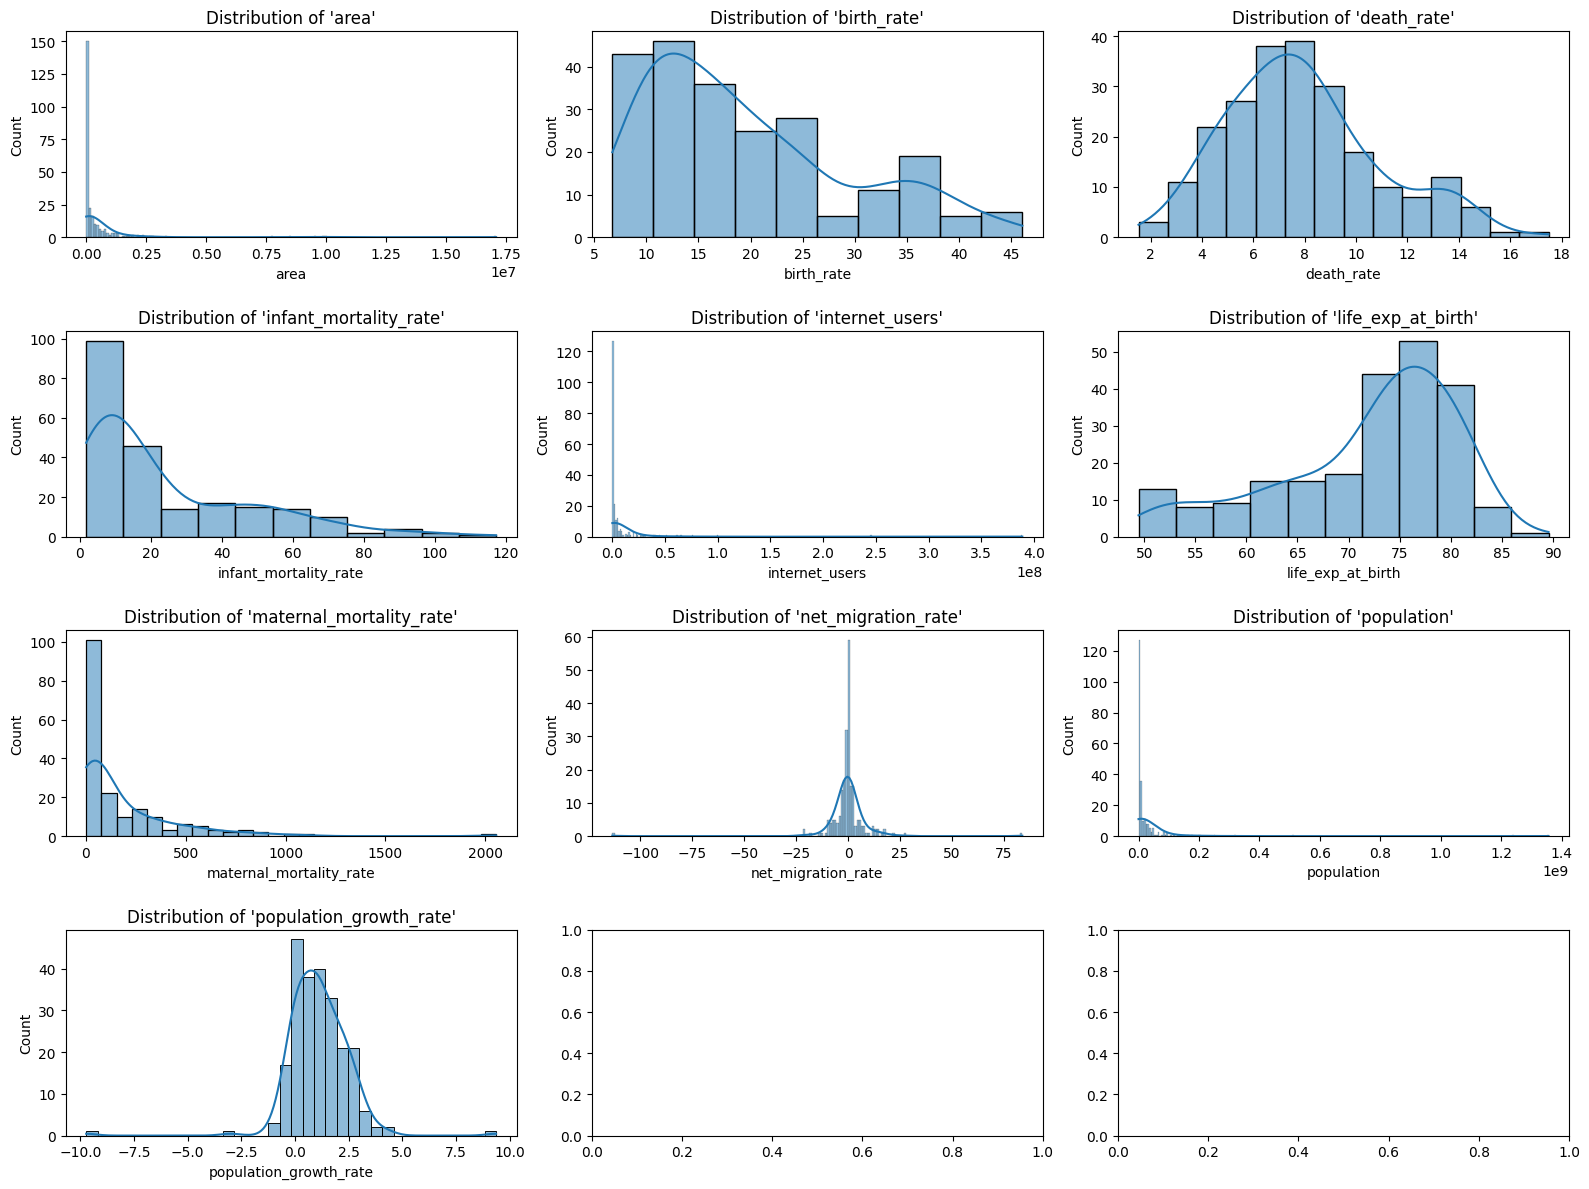

In [81]:
numerical_features = df.select_dtypes(include=[np.float64, np.int64])
num_cols = 3
num_rows = len(numerical_features.columns) // num_cols + 1

_, ax = plt.subplots(num_rows, num_cols, figsize=(16, 12))
for i, col in enumerate(numerical_features.columns):
    ax[i // num_cols, i % num_cols].set_title(f"Distribution of '{col}'")
    sns.histplot(data=numerical_features, x=col, ax=ax[i // num_cols, i % num_cols], kde=True)

plt.tight_layout(h_pad=2)
plt.show()

In [82]:
df["country"].value_counts().sort_values(ascending=False)

country
Russia              1
Vietnam             1
Sudan               1
United States       1
China               1
                   ..
Dhekelia            1
Bouvet Island       1
Palmyra Atoll       1
Akrotiri            1
Saint Barthelemy    1
Name: count, Length: 259, dtype: int64

In [83]:
df["country"].nunique()

259

In [84]:
df["country"].count()

259

This means the countries are unique from each other, thus problems may arise in feature engineering later on, as features are specific to each country. And it's too much of a hassle to actually look at trends between countries to fill missing data.

### $\textbf{2. Feature Engineering for Missing Data}$

**TASK: What countries have NaN for Agriculture? What is the main aspect of these countries?**

**TASK: Notice climate is missing for a few countries, but not the Region! Let's use this to our advantage. Fill in the missing Climate values based on the mean climate value for its region.**

Hints on how to do this: https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group

**TASK: Use the same method for the missing values in Literacy.**

`Note`: The tasks above are not possible as the dataset do not have the features required to make those possible. This is shown on the table below.

In [85]:
df.describe()

,area,birth_rate,death_rate,infant_mortality_rate,internet_users,life_exp_at_birth,maternal_mortality_rate,net_migration_rate,population,population_growth_rate
count,2.570000e+02,224.000000,225.000000,224.000000,2.130000e+02,224.000000,184.000000,222.000000,2.380000e+02,233.000000
mean,5.308881e+05,19.659063,7.906978,24.484420,8.311771e+06,71.826875,177.972826,-0.181577,3.229436e+07,1.100858
std,1.696869e+06,9.669575,2.979933,24.077809,3.350725e+07,8.798460,262.508297,11.142682,1.277013e+08,1.418633
min,0.000000e+00,6.720000,1.530000,1.810000,4.640000e+02,49.440000,2.000000,-113.510000,4.800000e+01,-9.730000
25%,6.160000e+02,11.840000,5.930000,6.185000,8.640000e+04,67.000000,20.000000,-2.015000,3.265865e+05,0.260000
50%,5.119700e+04,16.890000,7.630000,13.985000,7.164000e+05,74.360000,65.500000,-0.045000,5.220371e+06,1.020000
75%,3.381450e+05,24.915000,9.450000,38.655000,4.200000e+06,78.292500,240.000000,1.257500,1.826175e+07,1.920000
max,1.709824e+07,46.120000,17.490000,117.230000,3.890000e+08,89.570000,2054.000000,83.820000,1.355693e+09,9.370000


Due to the note above, I have modified this section to instead drop missing values of all the features available in the dataset by their mean feature values. This is done so, since it wouldn't make sense to use the mean values that encompasses global data to impute missing values of specific countries.


In [86]:
df.isna().sum()

country                     0
area                        2
birth_rate                 35
death_rate                 34
infant_mortality_rate      35
internet_users             46
life_exp_at_birth          35
maternal_mortality_rate    75
net_migration_rate         37
population                 21
population_growth_rate     26
dtype: int64

In [87]:
df.dropna(inplace=True)
df.isna().sum()

country                    0
area                       0
birth_rate                 0
death_rate                 0
infant_mortality_rate      0
internet_users             0
life_exp_at_birth          0
maternal_mortality_rate    0
net_migration_rate         0
population                 0
population_growth_rate     0
dtype: int64

### $\textbf{3. Data Feature Preparation}$

**TASK: Create a dummy variable to all categorical data.**

Not possible, since there is no categorical data. All features are numerical, with the exception of the country label, which is not categorical it acts more of an index.

**TASK: For numerical data perform standard scaler.**

In [88]:
numerical_features = df.select_dtypes(include=[np.float64, np.int64]).columns
scaler = StandardScaler()

df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,country,area,birth_rate,death_rate,infant_mortality_rate,internet_users,life_exp_at_birth,maternal_mortality_rate,net_migration_rate,population,population_growth_rate
0,Russia,8.214509,-0.893186,1.820347,-0.810215,0.849819,-0.055978,-0.587442,0.177896,0.732346,-0.832928
1,Canada,4.645581,-1.055161,0.062398,-0.906718,0.468688,1.253500,-0.686644,0.511636,-0.027544,-0.299672
2,United States,4.566314,-0.734286,0.011443,-0.847269,6.450246,1.013448,-0.646061,0.241786,1.977858,-0.292922
3,China,4.451064,-0.862431,-0.214670,-0.496274,10.400643,0.511728,-0.573914,0.008924,9.297515,-0.515674
4,Brazil,3.908176,-0.601015,-0.501292,-0.316297,1.813524,0.298980,-0.488240,0.023215,1.157254,-0.272672


### $\textbf{4. Creating and Fitting K-Means Model}$

**TASK:**

- Plot the within sum of squares vs. the number of cluster and find the optimal number of clusters.
- Fit a k-means model of the optimum cluster.

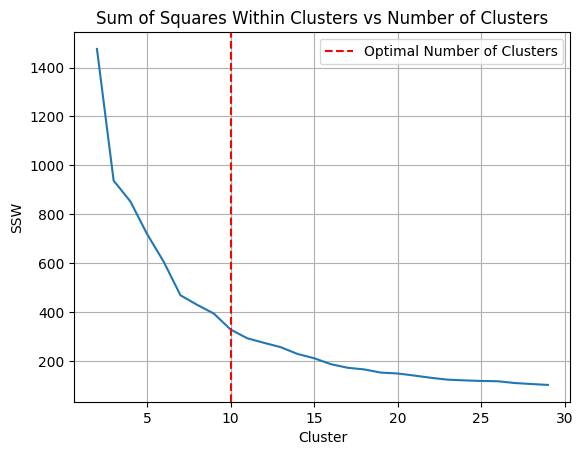

In [89]:
ssw = []

for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=42069, init='k-means++')
    kmeans.fit(df[numerical_features])
    ssw.append([k, kmeans.inertia_])

ssw = pd.DataFrame(ssw, columns=["Cluster", "SSW"])
kl = KneeLocator(x=ssw["Cluster"], y=ssw["SSW"], curve="convex", direction="decreasing", S=1, online=True)

optimum_cluster = kl.elbow
sns.lineplot(data=ssw, x="Cluster", y="SSW")
plt.axvline(x=optimum_cluster, color="red", linestyle="--", label="Optimal Number of Clusters")
plt.title("Sum of Squares Within Clusters vs Number of Clusters")
plt.grid(True)
plt.legend()
plt.show()

In [105]:
kmeans = KMeans(n_clusters=optimum_cluster, random_state=42069, init='k-means++')
df["cluster"] = kmeans.fit_predict(df[numerical_features])
df["cluster"] = df["cluster"].astype('category')
df.head()

,country,area,birth_rate,death_rate,infant_mortality_rate,internet_users,life_exp_at_birth,maternal_mortality_rate,net_migration_rate,population,population_growth_rate,cluster
0,Russia,8.214509,-0.893186,1.820347,-0.810215,0.849819,-0.055978,-0.587442,0.177896,0.732346,-0.832928,0
1,Canada,4.645581,-1.055161,0.062398,-0.906718,0.468688,1.253500,-0.686644,0.511636,-0.027544,-0.299672,0
2,United States,4.566314,-0.734286,0.011443,-0.847269,6.450246,1.013448,-0.646061,0.241786,1.977858,-0.292922,0
3,China,4.451064,-0.862431,-0.214670,-0.496274,10.400643,0.511728,-0.573914,0.008924,9.297515,-0.515674,5
4,Brazil,3.908176,-0.601015,-0.501292,-0.316297,1.813524,0.298980,-0.488240,0.023215,1.157254,-0.272672,0


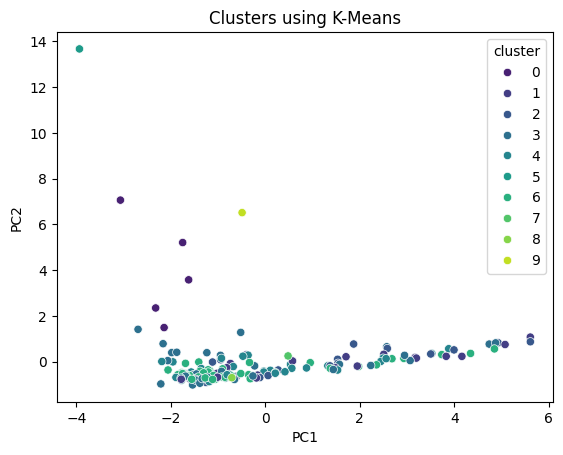

In [111]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(df[numerical_features])

reduced_df = pd.DataFrame(reduced_features, columns=["PC1", "PC2"])
reduced_df["cluster"] = df["cluster"]

sns.scatterplot(data=reduced_df, x="PC1", y="PC2", hue="cluster", palette="viridis")
plt.title("Clusters using K-Means")
plt.show()

### $\textbf{5. Model Interpretation}$

**TASK: What K value do you think is a good choice? Are there multiple reasonable choices? What features are helping define these cluster choices.**

In [112]:
optimum_cluster

10

A K value of 10 is a good choice, since it was calculated via the elbow method, which is a common way to evaluate how many clusters your dataset should optimally have. 10 clusters indicates that there is a significant amount of variation in the data, and there is a significant level of granularity in it.

However, using the elbow method is not the only choice when deciding the K value to use for the model. While it is a good starting point to consider the results of the elbow method, one should also consider other crucial factors such as domain knowledge and interpretability. It all depends whether the number of clusters align well with the underlying patterns in the data and are easy to interpret in the context of the problem. However, if the clusters seem overly fragmented or do not correspond to meaningful distinctions then going a cluster above or a cluster below the "optimum cluster" handed by the elbow method might be a good choice.

Additionally, examining feature importance and assessing the stability of the clusters can provide further insights into the robustness of the chosen K value and the quality of the clustering solution. Evaluating these factors collectively can help ensure that the selected number of clusters effectively captures the structure of your data and facilitates meaningful interpretation and decision-making.